In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

# 构建用于微笑检测的模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译微笑检测模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
# 加载数据
labels_file = '/Users/mac/Desktop/Mini Project/genki4k/labels.txt'
data = np.genfromtxt(labels_file, delimiter=' ')

y_train = data[:, 0]  # 微笑标签
head_poses = data[:, 1:]  # 头部姿态数据
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

# 重新整形X_train以适应模型输入
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)


In [88]:

# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print("测试准确率:", test_acc)


25/25 [==============================] - 1s 20ms/step - loss: 0.6942 - accuracy: 0.4787
测试准确率: 0.47874999046325684


3D头部姿态估计

In [89]:
# 训练头部姿态预测模型
history_regression = model_regression.fit(X_train, head_poses, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
80/80 [==============================] - 4s 48ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 2/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 3/10
80/80 [==============================] - 3s 42ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 4/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 5/10
80/80 [==============================] - 4s 46ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 6/10
80/80 [==============================] - 4s 46ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 7/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 8/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 9/10
80/80 [==============================] - 3s 44ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 10/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0318


25/25 [==============================] - 1s 21ms/step


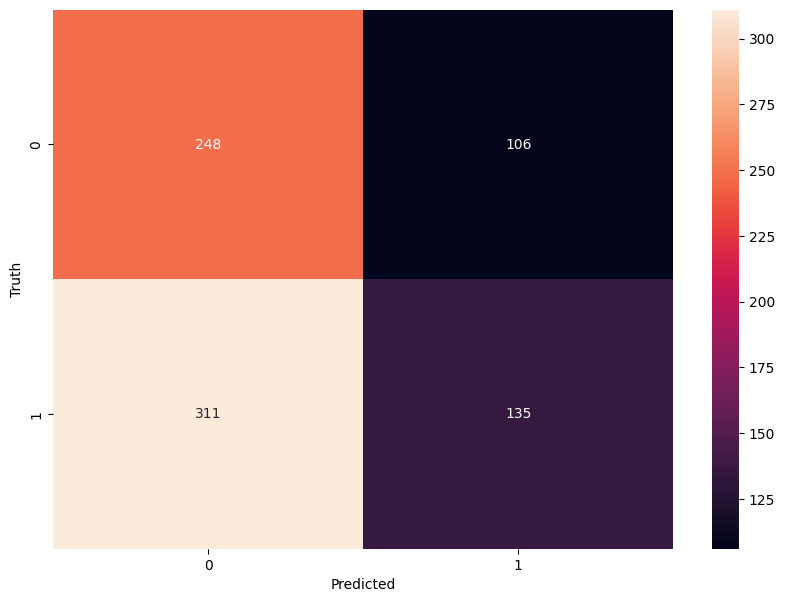

              precision    recall  f1-score   support

         0.0       0.44      0.70      0.54       354
         1.0       0.56      0.30      0.39       446

    accuracy                           0.48       800
   macro avg       0.50      0.50      0.47       800
weighted avg       0.51      0.48      0.46       800



In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 预测测试集
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# 打印分类报告
print(classification_report(y_test, y_pred_classes))


In [90]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import pyplot as plt


In [91]:
def grad_cam(model, image, class_idx, layer_name):
    # 定义损失函数
    def loss(output):
        return output[..., class_idx]

    gradcam = Gradcam(model, model_modifier=None, clone=False)
    
    # 正确处理图像的形状
    image = np.expand_dims(image, axis=0)

    # 生成Grad-CAM
    cam = gradcam(loss, seed_input=image, penultimate_layer=layer_name)
    cam = normalize(cam)

    plt.imshow(cam[0], cmap='jet', alpha=0.5)
    plt.show()

In [92]:
for layer in model.layers:
    print(layer.name)


conv2d_9
max_pooling2d_9
conv2d_10
max_pooling2d_10
flatten_5
dense_22
dropout_11
dense_23


In [94]:
def grad_cam_for_all_conv_layers(model, image, class_idx):
    # 确保图像形状正确
    if len(image.shape) == 2:  # 如果图像是灰度图（高度，宽度）
        image = np.expand_dims(image, axis=-1)  # 添加颜色通道维度
    if image.shape[0] != 64 or image.shape[1] != 64 or image.shape[2] != 1:
        raise ValueError("图像的形状必须是 (64, 64, 1)")
    image = np.expand_dims(image, axis=0)  # 添加批次维度

    # 遍历模型的所有层
    for layer in model.layers:
        # 检查层是否是卷积层
        if 'conv' in layer.name:
            print(f"Applying Grad-CAM to layer: {layer.name}")
            
            # 应用 Grad-CAM
            try:
                grad_cam(model, image, class_idx, layer.name)
            except ValueError as e:
                print(f"Error applying Grad-CAM to layer {layer.name}: {e}")
            plt.show()

# 调用函数
image_index = 0  # 示例：选择测试集中的第一个图像
class_idx = 1  # 假设1代表“微笑”

# 对测试集中的一个图像应用 Grad-CAM
grad_cam_for_all_conv_layers(model, X_test[image_index], class_idx)


Applying Grad-CAM to layer: conv2d_9
Error applying Grad-CAM to layer conv2d_9: seed_input's shape is invalid. model-input index: 0, model-input shape: (None, 64, 64, 1), seed_input shape: (1, 1, 64, 64, 1).
Applying Grad-CAM to layer: conv2d_10
Error applying Grad-CAM to layer conv2d_10: seed_input's shape is invalid. model-input index: 0, model-input shape: (None, 64, 64, 1), seed_input shape: (1, 1, 64, 64, 1).


In [95]:
# 假设您已经定义了一个名为 model_regression 的模型
# 以下是一个简单的示例结构，您可能需要根据实际情况进行调整

model_regression = Sequential([
    # 卷积层和池化层（与微笑检测模型类似）
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    # 更多层...
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3)  # 预测头部姿态的三个角度
])

model_regression.compile(optimizer='adam', loss='mean_squared_error')

# 训练头部姿态预测模型
history_regression = model_regression.fit(X_train, head_poses, epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10
80/80 [==============================] - 5s 47ms/step - loss: 0.1608 - val_loss: 0.0324
Epoch 2/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0285 - val_loss: 0.0322
Epoch 3/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0283 - val_loss: 0.0320
Epoch 4/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0282 - val_loss: 0.0319
Epoch 5/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0319
Epoch 6/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0319
Epoch 7/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 8/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 9/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 10/10
80/80 [==============================] - 4s 44ms/step - loss: 0.0281 - val_loss: 0.0318


In [105]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# 图像文件夹路径
image_folder = '/Users/mac/Desktop/Mini Project/genki4k/files'

# 加载图像数据
images = []
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):  # 假设所有图像都是 JPG 格式
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).convert('L')  # 转换为灰度图
        img = img.resize((64, 64))  # 假设您需要将图像调整为 64x64 尺寸
        images.append(np.asarray(img))

# 将列表转换为 NumPy 数组
images = np.array(images)
images = images.reshape(-1, 64, 64, 1)  # 重塑数组以适应模型输入

# 假设您已经正确加载了 labels 和 head_poses
# labels = ...
# head_poses = ...

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test, y_train_poses, y_test_poses = train_test_split(
    images, y_train, head_poses, test_size=0.2, random_state=42
)

# ...（其他代码，例如模型训练等）

# 使用模型预测测试集的头部姿态
head_poses_pred = model_regression.predict(X_test)

# 计算均方误差
mse = np.mean(np.square(head_poses_pred - y_test_poses))
print("头部姿态预测的均方误差:", mse)


25/25 [==============================] - 0s 13ms/step
头部姿态预测的均方误差: 0.028741834344139187
